In [83]:
import mediapipe as mp
import os
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

In [84]:
model_path = 'face_landmarker.task'

In [85]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.



def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)
 
  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    # solutions.drawing_utils.draw_landmarks(
    #     image=annotated_image,
    #     landmark_list=face_landmarks_proto,
    #     connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
    #     landmark_drawing_spec=None,
    #     connection_drawing_spec=mp.solutions.drawing_styles
    #     .get_default_face_mesh_tesselation_style())
    # solutions.drawing_utils.draw_landmarks(
    #     image=annotated_image,
    #     landmark_list=face_landmarks_proto,
    #     connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
    #     landmark_drawing_spec=None,
    #     connection_drawing_spec=mp.solutions.drawing_styles
    #     .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [86]:
from typing import Literal


def find_3D_centroid_of_facial_feature(face_landmarks, facial_feature : Literal['IRISES', 'NOSE', 'EYEBROWS'], image_dim):
    '''
    Takes in the face landmarks of a single face and returns the 3D centroid of the irises
    '''
    feature_to_connection = {
        "IRISES" : mp.solutions.face_mesh.FACEMESH_IRISES,
        "NOSE" : mp.solutions.face_mesh.FACEMESH_NOSE,
        "EYEBROWS" : frozenset().union(*[mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW, mp.solutions.face_mesh.FACEMESH_LEFT_EYEBROW]),
    }

    facial_connections = list(feature_to_connection[facial_feature])
    all_xs, all_ys, all_zs = [], [], []
    for tup in facial_connections:
        all_xs.append(face_landmarks[tup[0]].x * image_dim)
        all_xs.append(face_landmarks[tup[1]].x * image_dim)

        all_ys.append(face_landmarks[tup[0]].y * image_dim)
        all_ys.append(face_landmarks[tup[1]].y * image_dim)

        all_zs.append(face_landmarks[tup[0]].z * image_dim)
        all_zs.append(face_landmarks[tup[1]].z * image_dim)
    
    return (np.mean(all_xs), np.mean(all_ys), np.mean(all_zs))

# find_3D_centroid_of_irises(all_detection_results[0].face_landmarks[0])

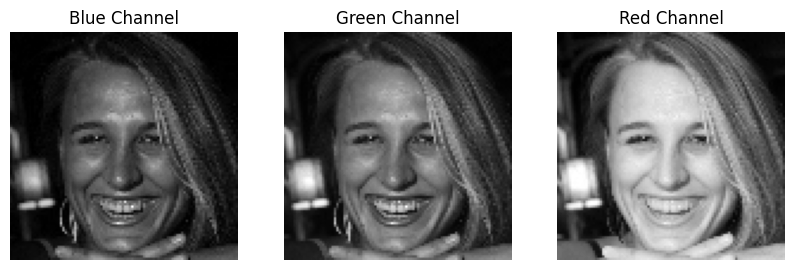

In [87]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\Data\AffectNet\happy\ffhq_0.png'
image = cv2.imread(image_path)

# Display the channels
if image is not None:
    # Split into channels
    channels = cv2.split(image)

    # Plot each channel
    plt.figure(figsize=(10, 3))
    titles = ['Blue Channel', 'Green Channel', 'Red Channel']
    for i, channel in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        plt.imshow(channel, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()
else:
    print("Error: Unable to load image.")


ffhq_1.png


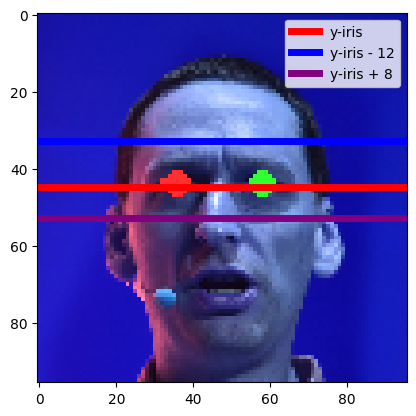

ffhq_10.png


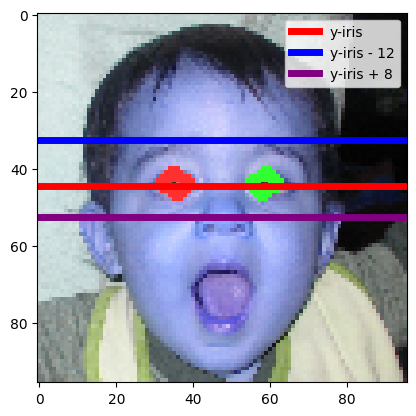

ffhq_100.png


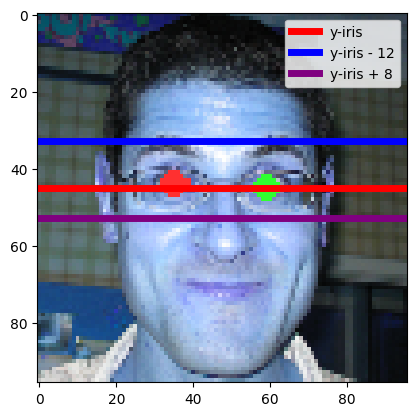

ffhq_101.png


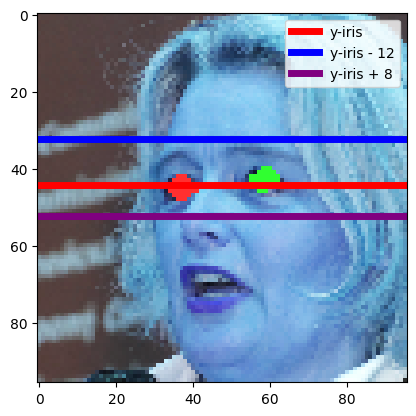

ffhq_102.png


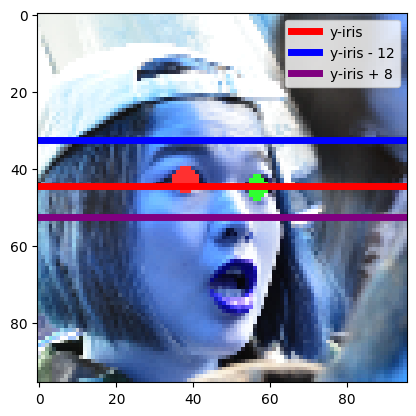

ffhq_103.png


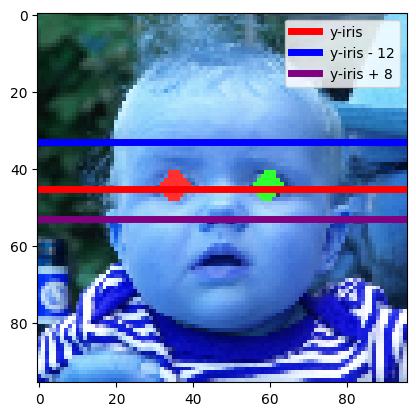

ffhq_104.png


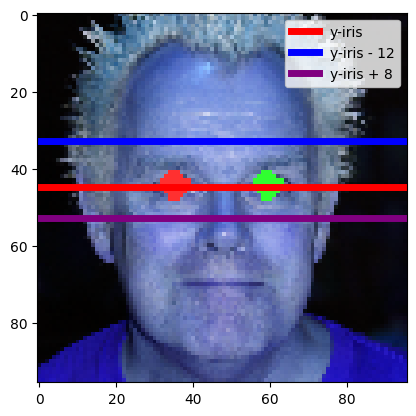

ffhq_105.png


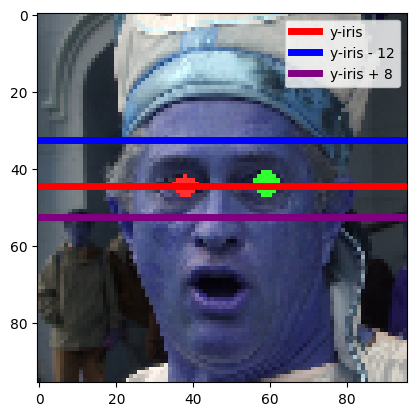

ffhq_106.png


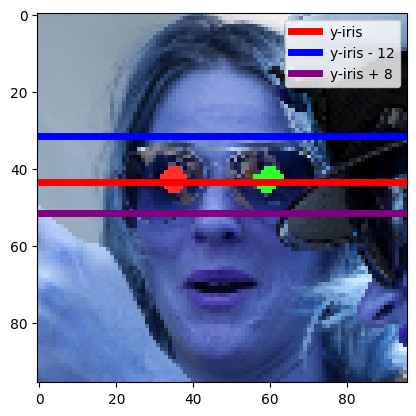

ffhq_108.png


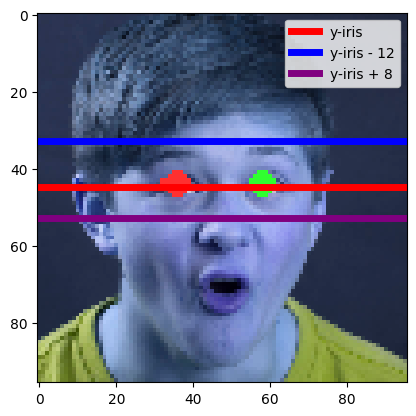

In [96]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

all_detection_results = []

with FaceLandmarker.create_from_options(options) as landmarker:
    # Load the input image from an image file.
    image_count = 0
    start_idx = 0
    max_images = 10
    for root, dirs, files in os.walk(r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\Data\AffectNet\surprise'):
        for i, file in enumerate(files):
            if file.endswith('.png') and i >= start_idx:
                image_path = os.path.join(root, file)
                image_count += 1

                mp_image = mp.Image.create_from_file(image_path)

                # Perform face landmarking on the provided single image.
                # The face landmarker must be created with the image mode.
                face_landmarker_result = landmarker.detect(mp_image)
                (x_iris, y_iris, z_iris) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'IRISES', 96)
                (x_nose, y_nose, z_nose) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'NOSE', 96)
                (x_eyebrows, y_eyebrows, z_eyebrows) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'EYEBROWS', 96)

                annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), face_landmarker_result)
                all_detection_results.append(face_landmarker_result)

                # Ensure the image is loaded
                if annotated_image is None:
                    print("Error: Image not found or unable to load.")
                else:
                    from matplotlib import pyplot as plt

                    img_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
                    plt.imshow(img_rgb, cmap='gray')
                    plt.axis('on')  # Turn off axis
                    # plt.axhline(y=y_iris, color='red', linewidth=5, label='y-iris')
                    # plt.axhline(y=y_nose, color='blue', linewidth=5, label='y-nose')
                    # plt.axhline(y=y_eyebrows, color='purple', linewidth=5, label='y-eyebrows')

                    plt.axhline(y=y_iris, color='red', linewidth=5, label='y-iris')
                    plt.axhline(y=y_iris - 12, color='blue', linewidth=5, label='y-iris - 12')
                    plt.axhline(y=y_iris + 8, color='purple', linewidth=5, label='y-iris + 8')
                    print(file)

                    plt.legend()
                    plt.show()

                if image_count == max_images:
                    break    

ffhq_0.png


C:\Users\najib\AppData\Local\Temp\ipykernel_94360\2246566784.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


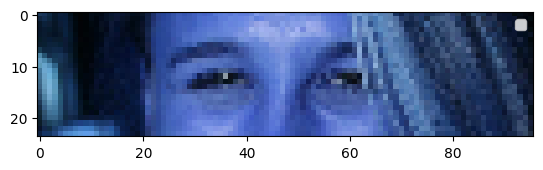

ffhq_1.png


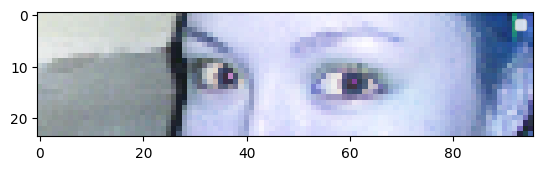

ffhq_10.png


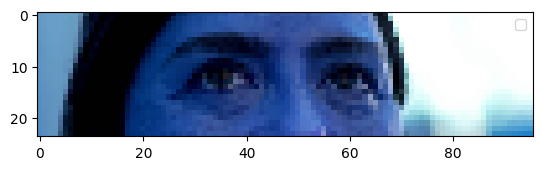

ffhq_100.png


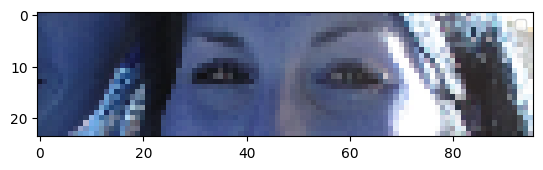

ffhq_1000.png


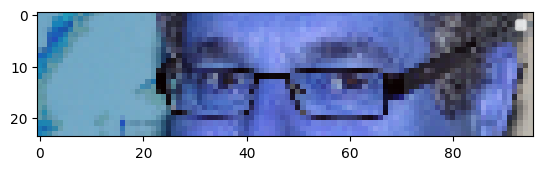

ffhq_1001.png


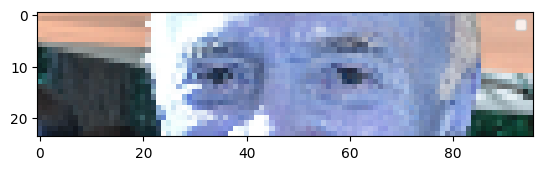

ffhq_1002.png


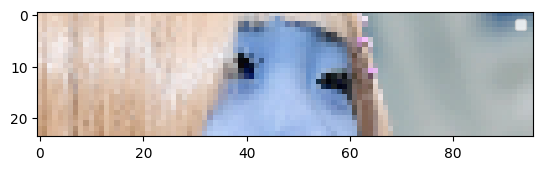

ffhq_1003.png


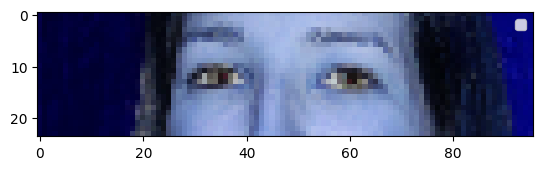

ffhq_1004.png


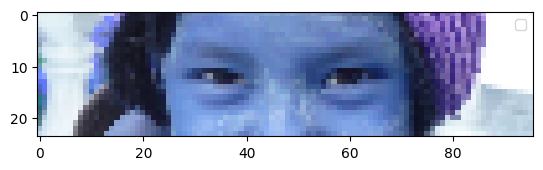

ffhq_1005.png


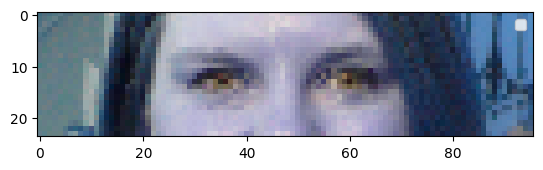

In [98]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

all_detection_results = []

with FaceLandmarker.create_from_options(options) as landmarker:
    # Load the input image from an image file.
    image_count = 0
    start_idx = 0
    max_images = 10
    for root, dirs, files in os.walk(r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\Data\AffectNet\happy'):
        for i, file in enumerate(files):
            if file.endswith('.png') and i >= start_idx:
                image_path = os.path.join(root, file)
                image_count += 1

                mp_image = mp.Image.create_from_file(image_path)

                # Perform face landmarking on the provided single image.
                # The face landmarker must be created with the image mode.
                face_landmarker_result = landmarker.detect(mp_image)
                (x_iris, y_iris, z_iris) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'IRISES', mp_image.numpy_view().shape[0])
                (x_nose, y_nose, z_nose) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'NOSE', mp_image.numpy_view().shape[0])
                (x_eyebrows, y_eyebrows, z_eyebrows) = find_3D_centroid_of_facial_feature(face_landmarker_result.face_landmarks[0], 'EYEBROWS', mp_image.numpy_view().shape[0])

                # annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), face_landmarker_result)
                all_detection_results.append(face_landmarker_result)

                # Ensure the image is loaded
                if annotated_image is None:
                    print("Error: Image not found or unable to load.")
                else:
                    from matplotlib import pyplot as plt

                
                    # Define the y-values for cropping
                    y_min, y_max = int(y_iris - 12), int(y_iris + 12)

                    # Perform the crop (OpenCV uses numpy slicing)
                    cropped_image = mp_image.numpy_view()[y_min:y_max, :]

                    img_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
                    plt.imshow(img_rgb)
                    plt.axis('on')  # Turn off axis
                    # plt.axhline(y=y_iris, color='red', linewidth=5, label='y-iris')
                    # plt.axhline(y=y_nose, color='blue', linewidth=5, label='y-nose')
                    # plt.axhline(y=y_eyebrows, color='purple', linewidth=5, label='y-eyebrows')

                    # plt.axhline(y=y_iris, color='red', linewidth=5, label='y-iris')
                    # plt.axhline(y=y_iris - 12, color='blue', linewidth=5, label='y-iris - 12')
                    # plt.axhline(y=y_iris + 8, color='purple', linewidth=5, label='y-iris + 8')
                    print(file)

                    plt.legend()
                    plt.show()

                if image_count == max_images:
                    break    

In [25]:
image_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images\angry\angry0.jpg'
mp_image = mp.Image.create_from_file(image_path)
mp_image.numpy_view().shape[0]

96

In [26]:
image_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images\angry\angry13123.jpg'
mp_image = mp.Image.create_from_file(image_path)
mp_image.numpy_view().shape

(48, 48)

In [ ]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

all_detection_results = []

with FaceLandmarker.create_from_options(options) as landmarker:
    # Load the input image from an image file.
    image_count = 0
    start_idx = 0
    max_images = 10
    source_dir_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images_cropped\happy'
    for root, dirs, files in os.walk(source_dir_path):
        for i, file in enumerate(files):
            if (file.endswith('.png') or file.endswith('.jpg')) and i >= start_idx:
                image_path = os.path.join(root, file)
                image_count += 1
                print(image_path.split('\\')[-1])

                # Load the image in grayscale
                img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Convert single-channel grayscale to 3-channel grayscale
                img_3channel_gray = cv2.merge([img_gray, img_gray, img_gray])

                # Convert 3-channel grayscale to MediaPipe format
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_3channel_gray)

                # Perform face landmarking on the provided single image.
                face_landmarker_result = landmarker.detect(mp_image)

                # Calculate feature centroids
                height = mp_image.numpy_view().shape[0]  # Height of the image
                landmark = face_landmarker_result.face_landmarks
                if landmark:
                    landmark = landmark[0]
                    (x_iris, y_iris, z_iris) = find_3D_centroid_of_facial_feature(landmark, 'IRISES', height)
                    (x_nose, y_nose, z_nose) = find_3D_centroid_of_facial_feature(landmark, 'NOSE', height)
                    (x_eyebrows, y_eyebrows, z_eyebrows) = find_3D_centroid_of_facial_feature(landmark, 'EYEBROWS', height)

                    # Save results
                    # all_detection_results.append(face_landmarker_result)

                    # Define the y-values for cropping with bounds validation
                    y_min = max(0, int(y_iris - 12))  # Ensure y_min is at least 0
                    y_max = min(height, int(y_iris + 12))  # Ensure y_max does not exceed image height

                    # Debugging: Print crop bounds and image dimensions
                    print(f"Image Height: {height}, y_min: {y_min}, y_max: {y_max}")

                    # Perform the crop (grayscale 3-channel image)
                    cropped_image = img_3channel_gray[y_min:y_max, :]

                    # Check if the cropped image is non-empty
                    if cropped_image.size == 0:
                        print(f"Skipping image {file}: Empty crop.")
                        continue

                    # Display the cropped grayscale image
                    plt.imshow(cropped_image, cmap='gray')
                    plt.axis('off')  # Turn off axis
                    plt.legend()
                    plt.show()

angry0.jpg
Image Height: 96, y_min: 28, y_max: 52
angry1.jpg
Image Height: 96, y_min: 27, y_max: 51
angry10.jpg
Image Height: 96, y_min: 28, y_max: 52
angry100.jpg
Image Height: 96, y_min: 26, y_max: 50
angry1000.jpg
Image Height: 96, y_min: 26, y_max: 50
angry10000.jpg
Skipping image angry10000.jpg: No face detected.
angry10001.jpg
Image Height: 48, y_min: 6, y_max: 30
angry10002.jpg
Image Height: 48, y_min: 2, y_max: 26
angry10003.jpg
Image Height: 48, y_min: 4, y_max: 28
angry10004.jpg
Image Height: 48, y_min: 7, y_max: 31
disgust0.jpg
Image Height: 96, y_min: 27, y_max: 51
disgust1.jpg
Image Height: 96, y_min: 28, y_max: 52
disgust10.jpg
Image Height: 96, y_min: 26, y_max: 50
disgust100.jpg
Image Height: 96, y_min: 28, y_max: 52
disgust1000.jpg
Image Height: 96, y_min: 28, y_max: 52
disgust1001.jpg
Image Height: 96, y_min: 27, y_max: 51
disgust1002.jpg
Image Height: 96, y_min: 27, y_max: 51
disgust1003.jpg
Image Height: 96, y_min: 29, y_max: 53
disgust1004.jpg
Image Height: 96, y_m

In [51]:
len(skipped_images)

6287

In [55]:
with open("no_face_detected_files.txt", "w") as file:
    for item in skipped_images:
        file.write(str(item) + "\n")

In [54]:
category_count  = {
    'angry': 0,
    'disgust': 0,
    'fear': 0,
    'happy': 0,
    'neutral': 0,
    'sad': 0,
    'surprise': 0
}

for file in skipped_images:
    for category in category_count.keys():
        if category in file:
            category_count[category] += 1
            break

category_count

{'angry': 1,
 'disgust': 189,
 'fear': 1561,
 'happy': 972,
 'neutral': 688,
 'sad': 2190,
 'surprise': 686}

In [ ]:
(y_iris + 12) - (y_iris - 8)

20.0

In [64]:
all_detection_results[0].face_landmarks[0]

[NormalizedLandmark(x=0.4812506437301636, y=0.7160047888755798, z=-0.057615868747234344, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.47180354595184326, y=0.6624094247817993, z=-0.14214187860488892, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4793171286582947, y=0.6765111088752747, z=-0.07550503313541412, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.45806458592414856, y=0.5679942965507507, z=-0.11457289755344391, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4718491733074188, y=0.6355275511741638, z=-0.15215077996253967, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4747190773487091, y=0.5974740982055664, z=-0.14455805718898773, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4843825697898865, y=0.5021511316299438, z=-0.08459889888763428, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.33106282353401184, y=0.4716123938560486, z=0.015294406563043594, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4875827729701996, y=

In [ ]:
# Connections for irises
facial_connections = list(mp.solutions.face_mesh.FACEMESH_IRISES)
facial_connections

[(475, 476),
 (477, 474),
 (469, 470),
 (472, 469),
 (471, 472),
 (474, 475),
 (476, 477),
 (470, 471)]

In [ ]:
facial_connections[0][0]

475

In [ ]:
facial_connections[0][1]

476

In [ ]:
all_detection_results[0].face_landmarks[0][facial_connections[0][0]]

NormalizedLandmark(x=0.6313607692718506, y=0.44121110439300537, z=-0.0021638779435306787, visibility=0.0, presence=0.0)

In [ ]:
all_detection_results[0].face_landmarks[0][facial_connections[0][1]]

NormalizedLandmark(x=0.6041984558105469, y=0.46420595049858093, z=-0.0021883794106543064, visibility=0.0, presence=0.0)

In [ ]:
'''
For each face landmark detection result, we need to get the main face contour landmarks and the iris/eyes/eyebrow landmarks.
Horizontally speaking:
    Find vertical midpoint of irises and pass a line through that to the end of the picture, this will be the width
    (96)

Vertically speaking:
    Draw a horizontal line at the nose tip + y maybe and another at the eyebrows + y again, this will be the height
    (top line - bottom line)
'''

'\nFor each face landmark detection result, we need to get the main face contour landmarks and the iris/eyes/eyebrow landmarks.\nHorizontally speaking:\n    Find vertical midpoint of irises and pass a line through that to the end of the picture, this will be the width\n    (96)\n\nVertically speaking:\n    Draw a horizontal line at the nose tip + y maybe and another at the eyebrows + y again, this will be the height\n    (top line - bottom line)\n'

In [ ]:
mp.solutions.face_mesh.FACEMESH_IRISES

frozenset({(469, 470),
           (470, 471),
           (471, 472),
           (472, 469),
           (474, 475),
           (475, 476),
           (476, 477),
           (477, 474)})

In [ ]:
all_detection_results[0].face_landmarks[0][facial_connections[0][1]]

NormalizedLandmark(x=0.6041984558105469, y=0.46420595049858093, z=-0.0021883794106543064, visibility=0.0, presence=0.0)

In [ ]:
def crop_images(source_dir_path, model_path):
    BaseOptions = mp.tasks.BaseOptions
    FaceLandmarker = mp.tasks.vision.FaceLandmarker
    FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    all_detection_results = []
    skipped_images = []

    with FaceLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image_count = 0
        for root, dirs, files in os.walk(source_dir_path):
            for i, file in enumerate(files):
                if file.endswith('.png') or file.endswith('.jpg'):
                    image_path = os.path.join(root, file)
                    image_count += 1
                    # print(image_path.split('\\')[-1])

                    # Load the image in grayscale
                    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    # Convert single-channel grayscale to 3-channel grayscale
                    img_3channel_gray = cv2.merge([img_gray, img_gray, img_gray])

                    # Convert 3-channel grayscale to MediaPipe format
                    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_3channel_gray)

                    # Perform face landmarking on the provided single image.
                    face_landmarker_result = landmarker.detect(mp_image)

                    # Calculate feature centroids
                    height = mp_image.numpy_view().shape[0]  # Height of the image
                    landmark = face_landmarker_result.face_landmarks
                    if landmark:
                        landmark = landmark[0]
                        (x_iris, y_iris, z_iris) = find_3D_centroid_of_facial_feature(landmark, 'IRISES', height)

                        # Define the y-values for cropping with bounds validation
                        y_min = max(0, int(y_iris - 12))  # Ensure y_min is at least 0
                        y_max = min(height, int(y_iris + 12))  # Ensure y_max does not exceed image height

                        # # Debugging: Print crop bounds and image dimensions
                        # print(f"Image Height: {height}, y_min: {y_min}, y_max: {y_max}")

                        # Perform the crop (grayscale 3-channel image)
                        cropped_image = img_3channel_gray[y_min:y_max, :]

                        # Check if the cropped image is non-empty
                        if cropped_image.size == 0:
                            print(f"Skipping image {file}: Empty crop.")
                            continue

                        if image_count % 5000 == 0:
                            print(f"Processed {image_count} images.")

                    else:
                        print(f"Skipping image {file}: No face detected.")
                        skipped_images.append(file)

source_dir_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images_cropped'
model_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_landmarker.task'
crop_images(source_dir_path, model_path)

In [82]:
import os
import cv2
import mediapipe as mp

def crop_images(source_dir_path, model_path):
    BaseOptions = mp.tasks.BaseOptions
    FaceLandmarker = mp.tasks.vision.FaceLandmarker
    FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    cropped_images = []
    skipped_images = []

    with FaceLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image_count = 0
        for root, dirs, files in os.walk(source_dir_path):
            # Check if the current folder is "angry"
            if os.path.basename(root) == 'angry':
                continue  # Skip processing this folder

            for file in files:
                if file.endswith('.png') or file.endswith('.jpg'):
                    image_path = os.path.join(root, file)
                    image_count += 1
                    print(image_path.split('\\')[-1])

                    # Load the image in grayscale
                    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    if img_gray.shape[0] < 30:
                        print(f"Skipping image {file}: Image already cropped.")
                        continue

                    # Convert single-channel grayscale to 3-channel grayscale
                    img_3channel_gray = cv2.merge([img_gray, img_gray, img_gray])

                    # Convert 3-channel grayscale to MediaPipe format
                    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_3channel_gray)

                    # Perform face landmarking on the provided single image.
                    face_landmarker_result = landmarker.detect(mp_image)

                    # Calculate feature centroids
                    height = mp_image.numpy_view().shape[0]  # Height of the image
                    landmark = face_landmarker_result.face_landmarks
                    if landmark:
                        landmark = landmark[0]
                        (x_iris, y_iris, z_iris) = find_3D_centroid_of_facial_feature(landmark, 'IRISES', height)

                        # Define the y-values for cropping with bounds validation
                        y_min = max(0, int(y_iris - 12))  # Ensure y_min is at least 0
                        y_max = min(height, int(y_iris + 12))  # Ensure y_max does not exceed image height

                        # Perform the crop (grayscale 3-channel image)
                        cropped_image = img_3channel_gray[y_min:y_max, :]

                        # Check if the cropped image is non-empty
                        if cropped_image.size == 0:
                            print(f"Skipping image {file}: Empty crop.")
                            continue

                        # Replace the original image with the cropped image
                        cv2.imwrite(image_path, cropped_image)
                        cropped_images.append(file)

                        if image_count % 5000 == 0:
                            print(f"Processed {image_count} images.")
                    else:
                        print(f"Skipping image {file}: No face detected.")
                        skipped_images.append(file)

    return skipped_images

source_dir_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images_cropped'
model_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_landmarker.task'
skipped_images = crop_images(source_dir_path, model_path)

disgust0.jpg
disgust1.jpg
disgust10.jpg
disgust100.jpg
disgust1000.jpg
disgust1001.jpg
disgust1002.jpg
disgust1003.jpg
disgust1004.jpg
disgust1005.jpg
disgust1006.jpg
disgust1007.jpg
disgust1008.jpg
disgust1009.jpg
disgust101.jpg
disgust1010.jpg
disgust1011.jpg
disgust1012.jpg
disgust1013.jpg
disgust1014.jpg
disgust1015.jpg
disgust1016.jpg
disgust1017.jpg
disgust1018.jpg
disgust1019.jpg
disgust102.jpg
disgust1020.jpg
disgust1021.jpg
disgust1022.jpg
disgust1023.jpg
disgust1024.jpg
disgust1025.jpg
disgust1026.jpg
disgust1027.jpg
disgust1028.jpg
disgust1029.jpg
disgust103.jpg
disgust1030.jpg
disgust1031.jpg
disgust1032.jpg
disgust1033.jpg
disgust1034.jpg
disgust1035.jpg
disgust1036.jpg
disgust1037.jpg
disgust1038.jpg
disgust1039.jpg
disgust104.jpg
disgust1040.jpg
disgust1041.jpg
disgust1042.jpg
disgust1043.jpg
disgust1044.jpg
disgust1045.jpg
disgust1046.jpg
disgust1047.jpg
disgust1048.jpg
disgust1049.jpg
disgust105.jpg
disgust1050.jpg
disgust1051.jpg
disgust1052.jpg
disgust1053.jpg
disgus

In [79]:
len(skipped_images)

1588

In [80]:
with open("no_face_detected_files_disgust.txt", "w") as file:
    for item in skipped_images:
        file.write(str(item) + "\n")

In [66]:
image_path = r'C:\Users\najib\Desktop\Uni\UW\ECE PMP\2024\Fall\EE P 596\Lab 9\EEP596D\Lab_9_Final_Project\face_images_cropped\angry\angry0.jpg'

# Load the image in grayscale
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [70]:
img_gray.shape[0]

24